# Bem-vindo ao Guia de início rápido do Amazon Forecast

Usar o Amazon Forecast envolve as 3 etapas a seguir.

![Amazon Forecast Workflow](https://github.com/aws-samples/amazon-forecast-samples/raw/main/notebooks/basic/Getting_Started/images/workflow.png)

Imagine que estejamos tentando resolver o problema de previsão de um serviço de táxi e queremos prever quantas corridas são esperadas em áreas específicas de Nova York. Para este exercício, usaremos os registros de viagem de táxi amarelo de [NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

Vamos começar por **importando os dados históricos de dezembro de 2017 a janeiro de 2019**. Em seguida, vamos **treinar um Predictor** usando esses dados. Finalmente, vamos **gerar uma previsão para fevereiro de 2019** e **compara-lo com os dados reais de fevereiro de 2019**.

## Sumário
* [Pre-requisites](#prerequisites)
* Etapa 1: [Importar os dados](#import)
* Etapa 2: [Treinar um preditor](#predictor)
* Etapa 3: [Gerar previsões](#forecast)
* [Clean-up](#cleanup)

## Pré-requisitos <a class="anchor" id="prerequisites"></a>
Antes de começarmos, vamos configurar o ambiente do notebook, o cliente AWS SDK para Amazon Forecast e IAM Role usado pela Amazon Forecast para acessar seus dados.

#### Configuração do ambiente do Notebook

In [1]:
%%capture --no-stderr setup

!pip install pandas s3fs matplotlib ipywidgets
!pip install boto3 --upgrade

%reload_ext autoreload

#### Importações de configuração

In [2]:
import sys
import os

sys.path.insert( 0, os.path.abspath("../../common") )

import json
import boto3
import s3fs
import pandas as pd
import time

#### Crie uma instância do cliente AWS SDK para Amazon Forecast

In [3]:
region = 'us-east-1'
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

# Verificando para ter certeza de que podemos nos comunicar com a Amazon Forecast
assert forecast.list_predictors()

#### Configure a função IAM usada pela Amazon Forecast para acessar seus dados

In [4]:
iam = boto3.resource('iam')
role_arn = iam.Role('LabRole').arn

## Etapa 1: Importar os dados. <a class="anchor" id="import"></a>

Nesta etapa, criaremos um **Dataset** e **importaremos** o conjunto de dados de dezembro de 2017 a janeiro de 2019 do S3 ao Amazon Forecast. Para treinar um Preditor, precisaremos de um **DatasetGroup** que agrupa a entrada **Dataset**. Então, vamos terminar esta etapa criando um **DatasetGroup** com o **Dataset** importado.

#### Dê uma olhada nos dados e carregue-os no S3.

O conjunto de dados de táxi tem as seguintes 3 colunas:
1. **timestamp:** Carimbo de data / hora em que as coletas são solicitadas.
2. **item_id:** Identificação do local de coleta.
3. **target_value:** Número de coletas solicitadas próximo ao carimbo de data / hora no local de coleta.

In [7]:
key="taxi-dec2017-jan2019.csv"

taxi_df = pd.read_csv(key, dtype = object, names=['timestamp','item_id','target_value'])

display(taxi_df.head(3))

bucket_name = '1678609923752774-forecastbucket-17evzbj31goij-victor'
print(f"\nTentativa de fazer upload dos dados para o bucket S3 '{bucket_name}' usando chave '{key}' ...")

s3 = boto3.Session().resource('s3')
bucket = s3.Bucket(bucket_name)
if not bucket.creation_date:
    if region != "us-east-1":
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
    else:
        s3.create_bucket(Bucket=bucket_name)

s3.Bucket(bucket_name).Object(key).upload_file(key)
ts_s3_path = f"s3://{bucket_name}/{key}"

print(f"\nFeito, o conjunto de dados é carregado para o S3 em {ts_s3_path}.")

,timestamp,item_id,target_value
0,2017-12-01 00:00:00,4,27
1,2017-12-01 00:00:00,7,36
2,2017-12-01 00:00:00,10,2



Tentativa de fazer upload dos dados para o bucket S3 '1678609923752774-forecastbucket-17evzbj31goij-victor' usando chave 'taxi-dec2017-jan2019.csv' ...

Feito, o conjunto de dados é carregado para o S3 em s3://1678609923752774-forecastbucket-17evzbj31goij-victor/taxi-dec2017-jan2019.csv.


#### Criando o Dataset

In [8]:
DATASET_FREQUENCY = "H" # H for hourly.
TS_DATASET_NAME = "TAXI_TSD"
TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"integer"
      }
   ]
}

create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                  DatasetType='TARGET_TIME_SERIES',
                                                  DatasetName=TS_DATASET_NAME,
                                                  DataFrequency=DATASET_FREQUENCY,
                                                  Schema=TS_SCHEMA)

ts_dataset_arn = create_dataset_response['DatasetArn']
describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)

print(f"O Dataset com ARN {ts_dataset_arn} está agora {describe_dataset_response['Status']}.")

O Dataset com ARN arn:aws:forecast:us-east-1:215789695050:dataset/TAXI_TSD está agora ACTIVE.


#### Importando o Dataset

In [9]:
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
TS_IMPORT_JOB_NAME = "TAXI_TTS_IMPORT"
TIMEZONE = "EST"

ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT,
                                       TimeZone = TIMEZONE)

ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)

print(f"Aguardando trabalho de importação de conjunto de dados com ARN {ts_dataset_import_job_arn} se tornar ACTIVE. Esse processo pode levar de 5 a 10 minutos.\n\nCurrent Status:")

class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")

# Aguarde a conclusão do conjunto de dados relacionado.
status_indicator = StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
print(f"\nO Dataset Import Job com ARN {ts_dataset_import_job_arn} está agora {describe_dataset_import_job_response['Status']}.")

Aguardando trabalho de importação de conjunto de dados com ARN arn:aws:forecast:us-east-1:215789695050:dataset-import-job/TAXI_TSD/TAXI_TTS_IMPORT se tornar ACTIVE. Esse processo pode levar de 5 a 10 minutos.

Current Status:
CREATE_PENDING ..
CREATE_IN_PROGRESS .....................................................................................................
ACTIVE 
O Dataset Import Job com ARN arn:aws:forecast:us-east-1:215789695050:dataset-import-job/TAXI_TSD/TAXI_TTS_IMPORT está agora ACTIVE.


#### Criando um DatasetGroup

In [10]:
DATASET_GROUP_NAME = "TAXI_DEMO"
DATASET_ARNS = [ts_dataset_arn]

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName=DATASET_GROUP_NAME,
                                  DatasetArns=DATASET_ARNS)

dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe_dataset_group_response = forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(f"O DatasetGroup com ARN {dataset_group_arn} está agora {describe_dataset_group_response['Status']}.")

O DatasetGroup com ARN arn:aws:forecast:us-east-1:215789695050:dataset-group/TAXI_DEMO está agora ACTIVE.


## Etapa 2: Treinar um Preditor <a class="anchor" id="predictor"></a>

Nesta etapa, criaremos um **Preditor** usando o **DatasetGroup** que foi criado acima. Depois de criar o preditor, revisaremos a precisão obtida por meio do processo de backtesting para obter uma compreensão quantitativa do desempenho do preditor.

#### Treinar um preditor

In [ ]:
PREDICTOR_NAME = "TAXI_PREDICTOR"
FORECAST_HORIZON = 24
FORECAST_FREQUENCY = "H"
HOLIDAY_DATASET = [{
        'Name': 'holiday',
        'Configuration': {
        'CountryCode': ['US']
    }
}]

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = FORECAST_HORIZON,
                                   ForecastFrequency = FORECAST_FREQUENCY,
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn, 
                                       'AdditionalDatasets': HOLIDAY_DATASET
                                    },
                                   ExplainPredictor = True)

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Esperando pelo Predictor com ARN {predictor_arn} se tornar ATIVO. Dependendo do tamanho dos dados e da configuração do preditor, pode levar várias horas para ficar ATIVO.\n\nCurrent Status:")

status_indicator = StatusIndicator()

while True:
    status = forecast.describe_auto_predictor(PredictorArn=predictor_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

print(f"\n\nO Preditor com ARN {predictor_arn} está agora {describe_auto_predictor_response['Status']}.")

Esperando pelo Predictor com ARN arn:aws:forecast:us-east-1:215789695050:predictor/TAXI_PREDICTOR_01HC37YNDMG1A3WN09GH03N4RP se tornar ATIVO. Dependendo do tamanho dos dados e da configuração do preditor, pode levar várias horas para ficar ATIVO.

Current Status:
CREATE_PENDING .
CREATE_IN_PROGRESS ...............................................................................................................................................................................................
CREATE_STOPPING ................................................................................................................
CREATE_STOPPED ............................................................................................

#### Rever métricas de precisão

* **Weighted Quantile Loss (wQL)** métrica mede a precisão de um modelo em um quantil especificado. É particularmente útil quando há custos diferentes para subestimar e superestimar.

* **Root Mean Square Error (RMSE)** usa o valor quadrado dos resíduos, o que amplifica o impacto de outliers. Em casos de uso em que apenas algumas grandes previsões erradas podem ser muito caras, o RMSE é a métrica mais relevante.

* **Weighted Absolute Percentage Error (WAPE)** é mais robusto para outliers do que Root Mean Square Error (RMSE) porque usa o erro absoluto em vez do erro quadrado.

* **Mean Absolute Percentage Error (MAPE)** é útil para casos em que os valores diferem significativamente entre os pontos de tempo e os valores discrepantes têm um impacto significativo.

* **Mean Absolute Scaled Error (MASE)** é ideal para conjuntos de dados de natureza cíclica ou com propriedades sazonais.

In [27]:
get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")

print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")

print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")

print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")

print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

Weighted Quantile Loss (wQL): [
  {
    "Quantile": 0.9,
    "LossValue": 0.059667972033150815
  },
  {
    "Quantile": 0.5,
    "LossValue": 0.11829382821794981
  },
  {
    "Quantile": 0.1,
    "LossValue": 0.05405069629728868
  }
]


Root Mean Square Error (RMSE): 16.694313195151636


Weighted Absolute Percentage Error (WAPE): 0.11886763306802807


Mean Absolute Percentage Error (MAPE): 0.22740875541877484


Mean Absolute Scaled Error (MASE): 0.6322461044843267



## Etapa 3: Gerando previsões <a class="anchor" id="forecast"></a>
Finalmente, geraremos as previsões usando o preditor acima. Posteriormente nesta etapa, também compararemos a previsão com a verdade básica para 1º de fevereiro de 2019 para demonstrar o desempenho real da Amazon Forecast neste conjunto de dados.

#### Gerando previsões

In [30]:
FORECAST_NAME = "TAXI_FORECAST"

status_indicator = StatusIndicator()

while True:
    status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")

CREATE_IN_PROGRESS .....................................................................
ACTIVE 

The Forecast with ARN arn:aws:forecast:us-east-1:397232138439:forecast/TAXI_FORECAST is now ACTIVE.


#### Carregue informações reais sobre o local de coleta 48 em 1º de fevereiro de 2019.

In [31]:
ITEM_ID = "48"

taxi_feb_df = pd.read_csv("taxi-feb2019.csv", dtype = object, names=['timestamp','item_id','target_value'])
taxi_feb_df.target_value = taxi_feb_df.target_value.astype(float)

actuals = taxi_feb_df[(taxi_feb_df['item_id'] == ITEM_ID)]

#### Previsões de consulta para o local de coleta 48 em 1º de fevereiro de 2019.

In [32]:
forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": ITEM_ID}
)

forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

#### Compare as previsões com o valor real

<AxesSubplot:xlabel='timestamp'>

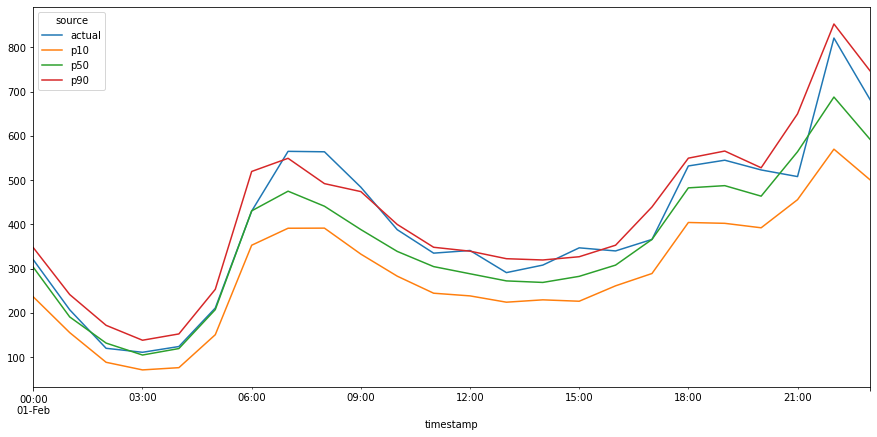

In [34]:
import dateutil

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'} , ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

## Clean-up <a class="anchor" id="cleanup"></a>
Remova o comentário da seção de código para excluir todos os recursos que foram criados neste bloco de notas.

In [ ]:
# forecast.delete_resource_tree(ResourceArn = dataset_group_arn)
# forecast.delete_resource_tree(ResourceArn = ts_dataset_arn)